In [ ]:
! pip install jsonlines
! pip install fast_ml --quiet
! pip install transformers
! pip install nltk
! python -m nltk.downloader all
! pip install unidecode
! pip install textblob
from unidecode import unidecode
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
import tensorflow as tf
import transformers
from textblob import TextBlob

In [ ]:
import jsonlines
# open annotated Json-L file
list_file = jsonlines.open('/content/drive/MyDrive/Dissertation/admin.jsonl')
documents=[]
for i in list_file:
  documents.append(i)

In [ ]:
# Extract corresponding text and store in a pandas dataframe
import pandas as pd
def index(document):
  training = pd.DataFrame(columns=['label','Text'])
  for i in range(0,len(document)):
    text = documents[i].get("text")
    entities = documents[i].get("label")
    for z in range(0,len(entities)):
      start_offset = entities[z][0]
      end_offset = entities[z][1]
      label = entities[z][2]
      text_ext = text[start_offset:end_offset] #Extract text by its position in list
      list_row = {'label': label, 'Text': text_ext}
      training = training.append(list_row,ignore_index=True)
      z+=1
    i+=1
  return training
result = index(documents)

In [ ]:
# Preprocess the dataset for word embedding
def pre_process(text):
    # convert input corpus to lower case.
    text = text.lower()
    # collecting a list of stop words from nltk and punctuation form
    # string class and create single array.
    stopset = stopwords.words('english') + list(string.punctuation)
    # remove stop words and punctuations from string.
    # word_tokenize is used to tokenize the input corpus in word tokens.
    text = " ".join([i for i in word_tokenize(text) if i not in stopset])
    return text

# Lemmatization and spell check
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
lemmatizer = WordNetLemmatizer()

# Word Tokenisationb & Lemmatization
def word_token(sentence):
  words = word_tokenize(sentence)
  for w in range(0,len(words)):
    words[w]=lemmatizer.lemmatize(words[w])
    w+=1
  words = ' '.join(words)
  return words

# Combination of preprocess spelling and lemetization funcitons
def lemmatization(dataset):
  processed_text = []
  for i in range(0,len(dataset)):
    text = dataset.iloc[i][1]
    text_new = pre_process(text)
    word_orig = word_token(text_new)
    processed_text.append(word_orig)
    i+=1
  dataset['processed_text'] = processed_text
  return dataset
# Apply to result
lemmatization(result)
result = result.drop('Text',axis=1)

In [ ]:
# Map Label to columns
result['label_cat'] = result['label']
result['label_cat'] = pd.factorize(result['label_cat'])[0]

In [ ]:
# Save the dataset as a parquet file
result.to_parquet('/content/drive/MyDrive/Dissertation/Data/df.parquet')

In [ ]:
# Split the dataset into train and test dataset
from sklearn.model_selection import train_test_split
# Due to imbalance in class labels, use stratified spliting on label_cat
X= result['processed_text']
y= result['label_cat']
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [ ]:
# concatenate X and y variables into one dataset and store as parquet files
train_df = pd.concat([train_x,train_y],axis=1)
test_df = pd.concat([test_x,test_y],axis=1)
train_df.to_parquet('/content/drive/MyDrive/Dissertation/Data/train_df.parquet')
test_df.to_parquet('/content/drive/MyDrive/Dissertation/Data/test_df.parquet')

In [ ]:
# Load data
import pandas as pd
result = pd.read_parquet('/content/drive/MyDrive/Dissertation/Data/df.parquet')

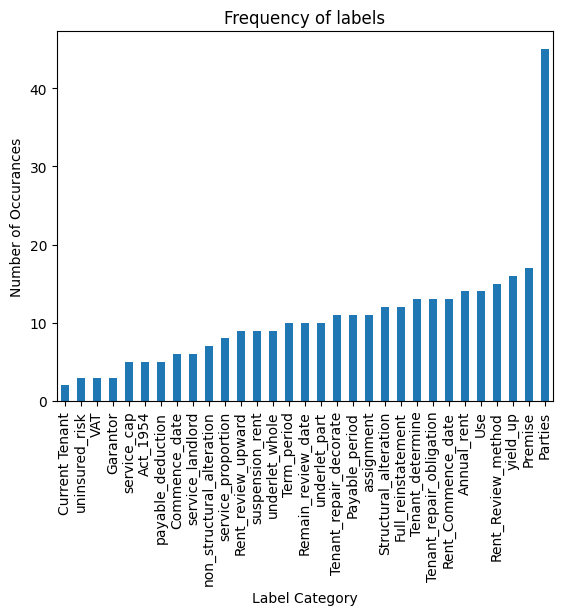

In [ ]:
# Visualise frequency of labelling
import matplotlib.pyplot as plt
list_count = result['label'].value_counts(ascending=True).plot(kind='bar',
                                                                     title='Frequency of labels',
                                                                     xlabel= 'Label Category',
                                                                     ylabel = 'Number of Occurances')
# Save figure
fig = list_count.get_figure()
fig.savefig('/content/drive/MyDrive/Dissertation/Data/Label_distribution.png', bbox_inches="tight")